<a href="https://colab.research.google.com/github/bubriks/ID2223/blob/main/Project/project-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Course Project: Scalable Machine Learning and Deep Learning**

## **Paolo Teta & Ralfs Zangis**
---

# **Requirements**

**Spark**

In [1]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = SparkSession.builder.getOrCreate()

     |████████████████████████████████| 281.3 MB 25 kB/s 
     |████████████████████████████████| 198 kB 40.2 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=d0fd4502936374b24577966ba1cf7714aadbfb51f8ac27cfbbd22257ce603a56
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


**Tensorflow**

In [2]:
import tensorflow as tf
import tensorflow.keras.backend as K

**Other**

In [3]:
import numpy as np
import matplotlib.pyplot as plt

**Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
# **1. Get the data**

**Link:** https://drive.google.com/file/d/1Du-gZz1LU-StWbahzckG1EmSLC-FuW5S/view?usp=sharing

In [5]:
schema = StructType([
    StructField("emotion", IntegerType(), True),
    StructField("pixels", StringType(), True),
    StructField("Usage", StringType(), True)])

data = spark.read.csv("/content/drive/MyDrive/Colab Notebooks/dataset-project.csv", header=True, schema=schema)
data = data.withColumn("id", monotonically_increasing_id())
data = data.withColumn("pixels", split(col("pixels"), " ").cast("array<int>"))

---
# **2. Explore the data**

In [6]:
data.printSchema()
print((data.count(), len(data.columns)))

root
 |-- emotion: integer (nullable = true)
 |-- pixels: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- Usage: string (nullable = true)
 |-- id: long (nullable = false)

(35887, 4)


In [7]:
data.show(5)

+-------+--------------------+--------+---+
|emotion|              pixels|   Usage| id|
+-------+--------------------+--------+---+
|      0|[70, 80, 82, 72, ...|Training|  0|
|      0|[151, 150, 147, 1...|Training|  1|
|      2|[231, 212, 156, 1...|Training|  2|
|      4|[24, 32, 36, 30, ...|Training|  3|
|      6|[4, 0, 0, 0, 0, 0...|Training|  4|
+-------+--------------------+--------+---+
only showing top 5 rows



In [8]:
data.select("Usage").distinct().collect()

[Row(Usage='Training'), Row(Usage='PublicTest'), Row(Usage='PrivateTest')]

In [9]:
data.groupBy(col("emotion")).count().sort(asc("emotion")).show()

+-------+-----+
|emotion|count|
+-------+-----+
|      0| 4953|
|      1|  547|
|      2| 5121|
|      3| 8989|
|      4| 6077|
|      5| 4002|
|      6| 6198|
+-------+-----+



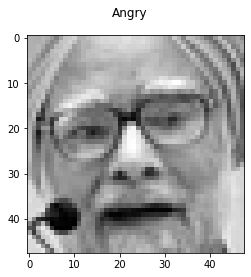

In [10]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

dataId = 1

row = data.filter(col("id") == dataId).first()
plt.figure(dataId)
pixelArray = np.asarray(row["pixels"])
plt.suptitle(emotion_labels[row["emotion"]])
plt.imshow(pixelArray.reshape((48, 48)), interpolation='none', cmap='gray')

---
# **3. Prepare data**

Normalize pixels

In [11]:
normalizeUdf = udf(lambda pixelArray: [pixel/255 for pixel in pixelArray],
                   ArrayType(FloatType()))

data = data.withColumn("pixels", normalizeUdf(col("pixels")))

Reshape pixels

In [12]:
reshapeUdf = udf(lambda pixelArray: np.array(pixelArray).reshape((1, 48, 48)).tolist(),
                 ArrayType(ArrayType(ArrayType(FloatType()))))

data = data.withColumn("pixels", reshapeUdf(col("pixels")))

Separate dataset

In [13]:
train_set = data.filter(col("Usage") == "Training").select("emotion", "pixels")
val_set = data.filter(col("Usage") == "PublicTest").select("emotion", "pixels")
test_set = data.filter(col("Usage") == "PrivateTest").select("emotion", "pixels")

---
# **4. Make model**

In [14]:
df_train = train_set.toPandas()

ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-8c38c4b919c0>", line 1, in <module>
    df_train = train_set.toPandas()
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/pandas/conversion.py", line 157, in toPandas
    pdf = pd.DataFrame.from_records(self.collect(), columns=self.columns)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/dataframe.py", line 693, in collect
    sock_info = self._jdf.collectToPython()
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1310, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/local/lib/python3.7/dist-packages/pyspark/sql/utils.py", line 111, in deco
    return f(*a, **kw)
  File "/usr/local/lib/python3.7/dist-packages/py4j/protocol.py", line 328, in get_

ConnectionRefusedError: ignored

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        zoom_range = 0.0,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False)

datagen.fit(df_train["pixels"].values.tolist())

In [ ]:
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, min_delta=0.0001, patience=1, verbose=1)

In [ ]:
K.set_image_data_format('channels_first')

def swish_activation(x):
    return (K.sigmoid(x) * x)

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(1,48,48)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding="same", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(96, (3, 3), padding="valid", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding="valid", activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation=swish_activation))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(7 , activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam' ,
              metrics=['accuracy'])

print(model.summary())

In [ ]:
tf.keras.utils.plot_model(model)

---
# **5. Train model**

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam' , metrics=['accuracy'])

In [ ]:
df_val = val_set.toPandas()

In [ ]:
batch_size = 128
epochs = 14

history = model.fit_generator(
    datagen.flow(df_train["pixels"].values.tolist(), df_train["emotion"].values.tolist(), batch_size=batch_size),
    callbacks=[lr_reduce],
    validation_data=(df_val["pixels"].values.tolist(), df_val["emotion"].values.tolist()),
    epochs = epochs,
    verbose = 2)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

---
# **6. Prediction**

In [ ]:
%matplotlib notebook

import cv2
import matplotlib.pyplot as plt
import signal

In [ ]:
def signal_handler(signal, frame):
    # KeyboardInterrupt detected, exiting
    global is_interrupted
    is_interrupted = True

In [ ]:
vc = cv2.VideoCapture(0)

plt.ion()

if vc.isOpened(): # try to get the first frame
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview = plt.imshow(frame)    
else:
    is_capturing = False

signal.signal(signal.SIGINT, signal_handler)
is_interrupted = False
while is_capturing:
    is_capturing, frame = vc.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    # makes the blues image look real colored
    webcam_preview.set_data(frame)
    plt.draw()

    try:    # Avoids a NotImplementedError caused by `plt.pause`
        plt.pause(0.05)
    except Exception:
        pass
    if is_interrupted:
        vc.release()
        break